In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501.xlsx


In [ ]:
df = pd.read_excel('202501.xlsx')

In [ ]:
# 시간 컬럼 datetime 변환 (Pump-Begin 기준)
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])

In [ ]:
# 금속 컬럼 추출
metal_columns = [col for col in df.columns if '(ng/m3)' in col]

In [ ]:
# 음수값 전처리
df[metal_columns] = df[metal_columns].apply(lambda col: col.where(col >= 0))
df = df.dropna(subset=metal_columns, how='all')

In [ ]:
# 날짜 컬럼 생성
df['Date'] = df['Pump-Begin'].dt.date

# 날짜 분할 (11일 단위)
unique_dates = sorted(df['Date'].unique())
chunks = [unique_dates[i:i+11] for i in range(0, len(unique_dates), 11)]

In [ ]:
# 금속별 최대값 설정
metal_max_dict = {metal: df[metal].max() * 1.1 for metal in metal_columns}

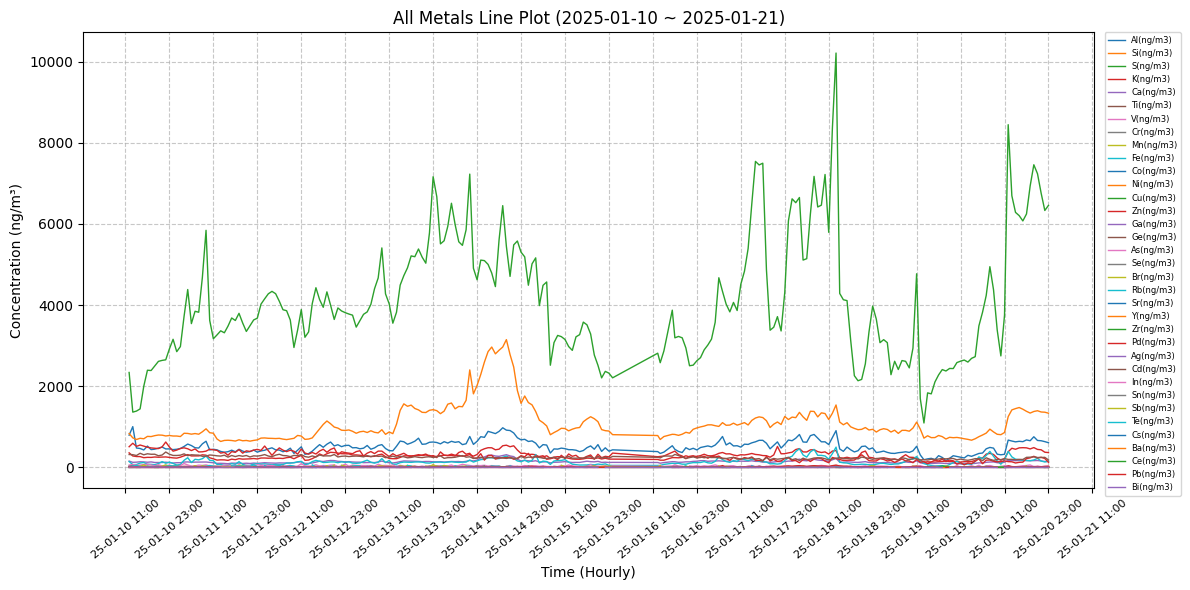

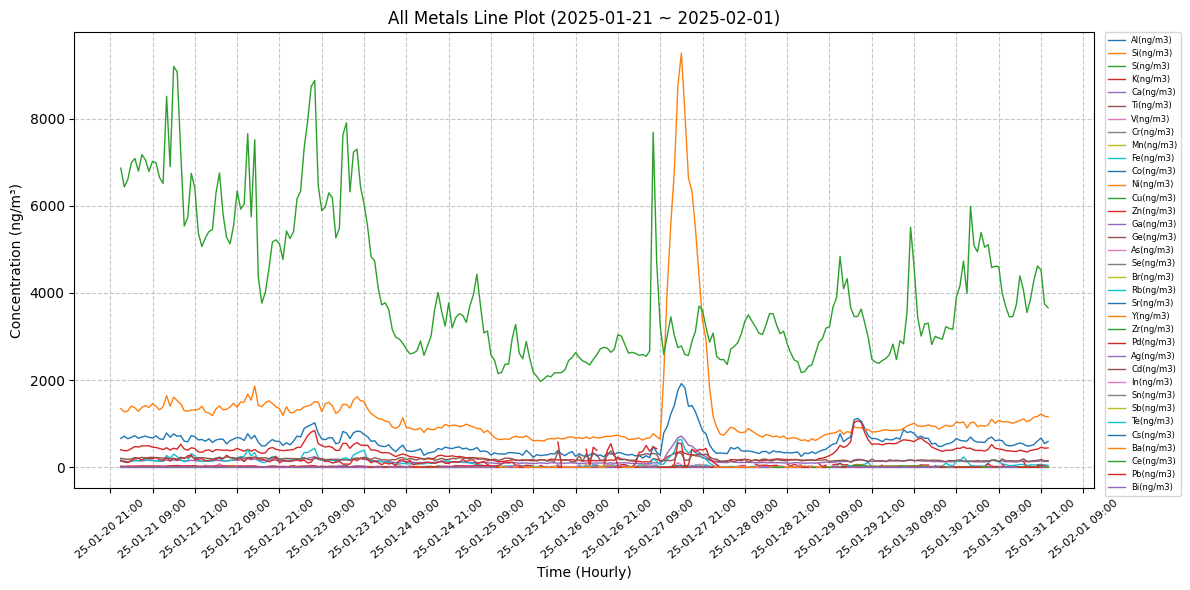

In [ ]:
from types import FunctionType
# 전체 금속 선 그래프 그리기
for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date = pd.to_datetime(max(date_group)) + pd.Timedelta(days=1)

    temp_df = df[(df['Pump-Begin'] >= start_date) &
                 (df['Pump-Begin'] < end_date)].copy()
    temp_df = temp_df.sort_values('Pump-Begin')

    plt.figure(figsize=(12, 6))

    # 모든 금속 선 그리기
    for metal in metal_columns:
        plt.plot(temp_df['Pump-Begin'], temp_df[metal], label=metal, linewidth=1)

    # x축 설정 (12시간 단위로 표시, 데이터는 1시간 단위)
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
    plt.xticks(rotation=40, fontsize=8)

    # 격자 설정
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # 제목과 라벨
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Concentration (ng/m³)')
    plt.title(f'All Metals Line Plot ({start_date.date()} ~ {end_date.date()})')

    # 범례 설정
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1),
               fontsize=6, ncol=1, borderaxespad=0)

    # 그래프 출력
    plt.tight_layout()
    plt.show()

Saving 202501_04_clean.xlsx to 202501_04_clean (4).xlsx
Loaded: 202501_04_clean (4).xlsx
Group1 metals: ['Cr(µg/m3)', 'Co(µg/m3)', 'Ni(µg/m3)', 'As(µg/m3)', 'Sb(µg/m3)', 'Pb(µg/m3)']
Group2 metals: ['Cd(µg/m3)']
월별 구간: [Period('2025-01', 'M'), Period('2025-02', 'M'), Period('2025-03', 'M'), Period('2025-04', 'M')]


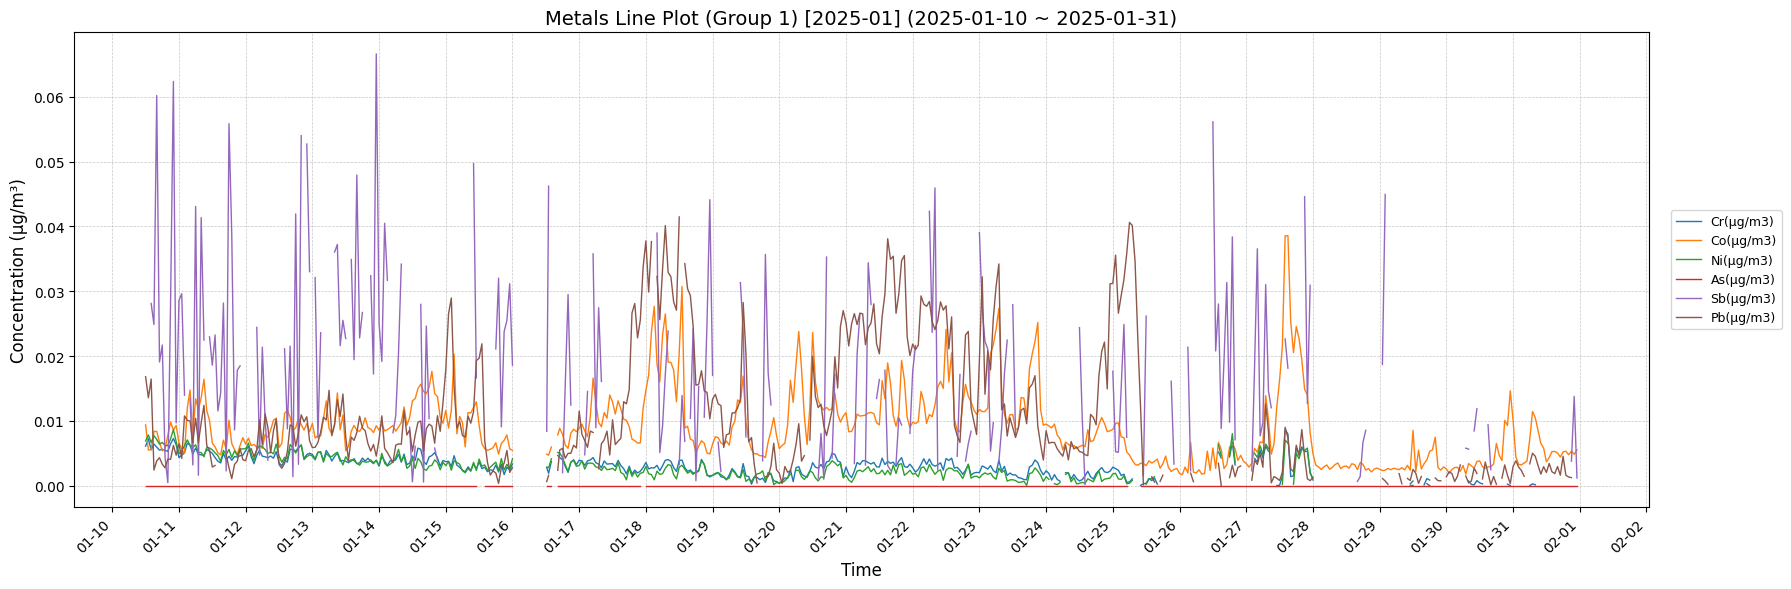

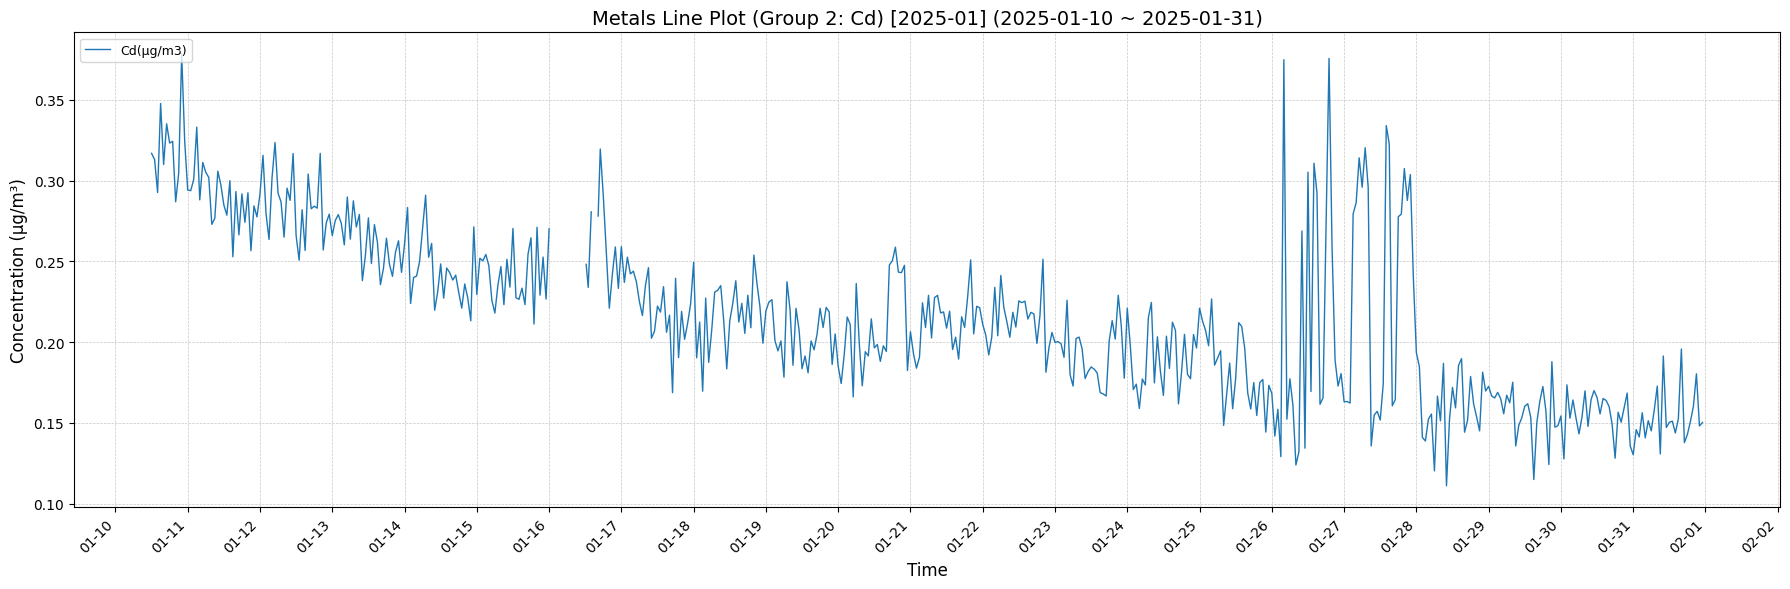

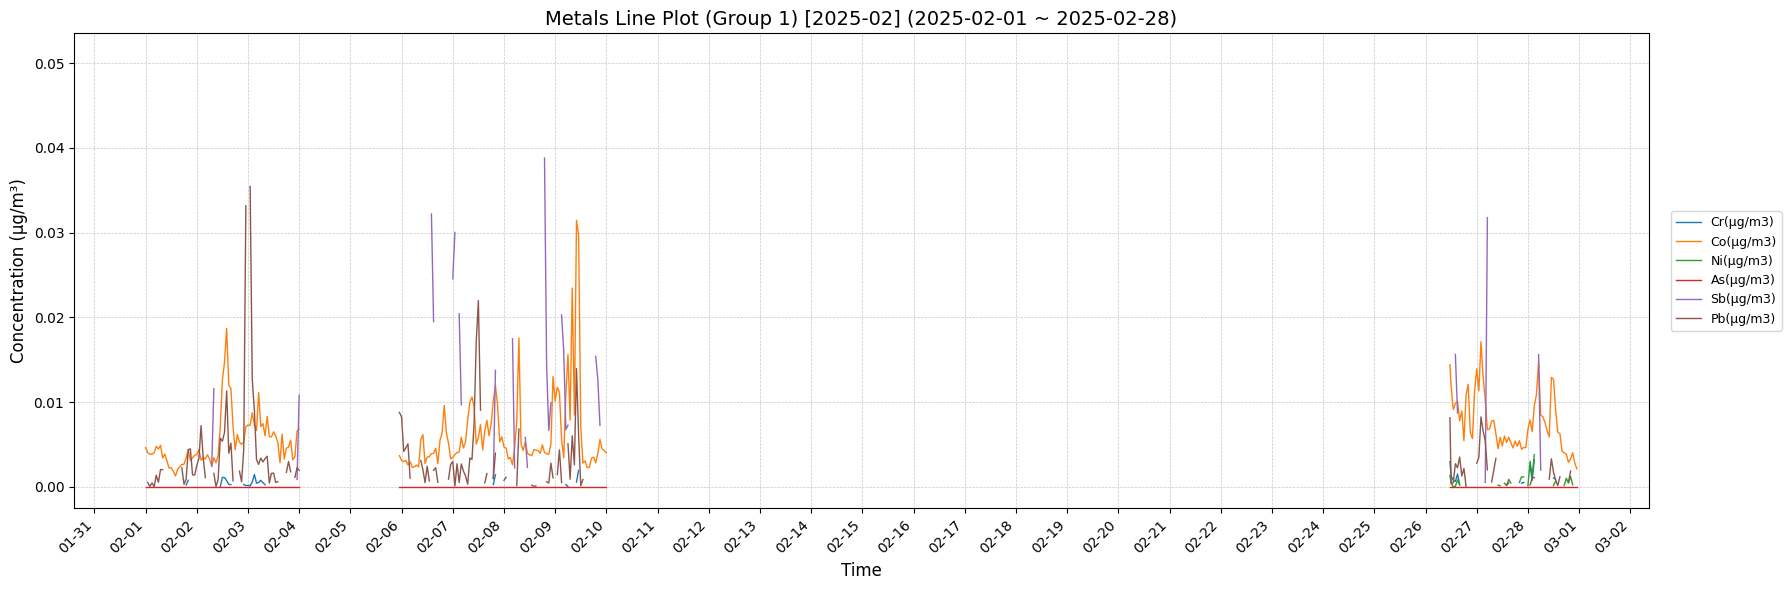

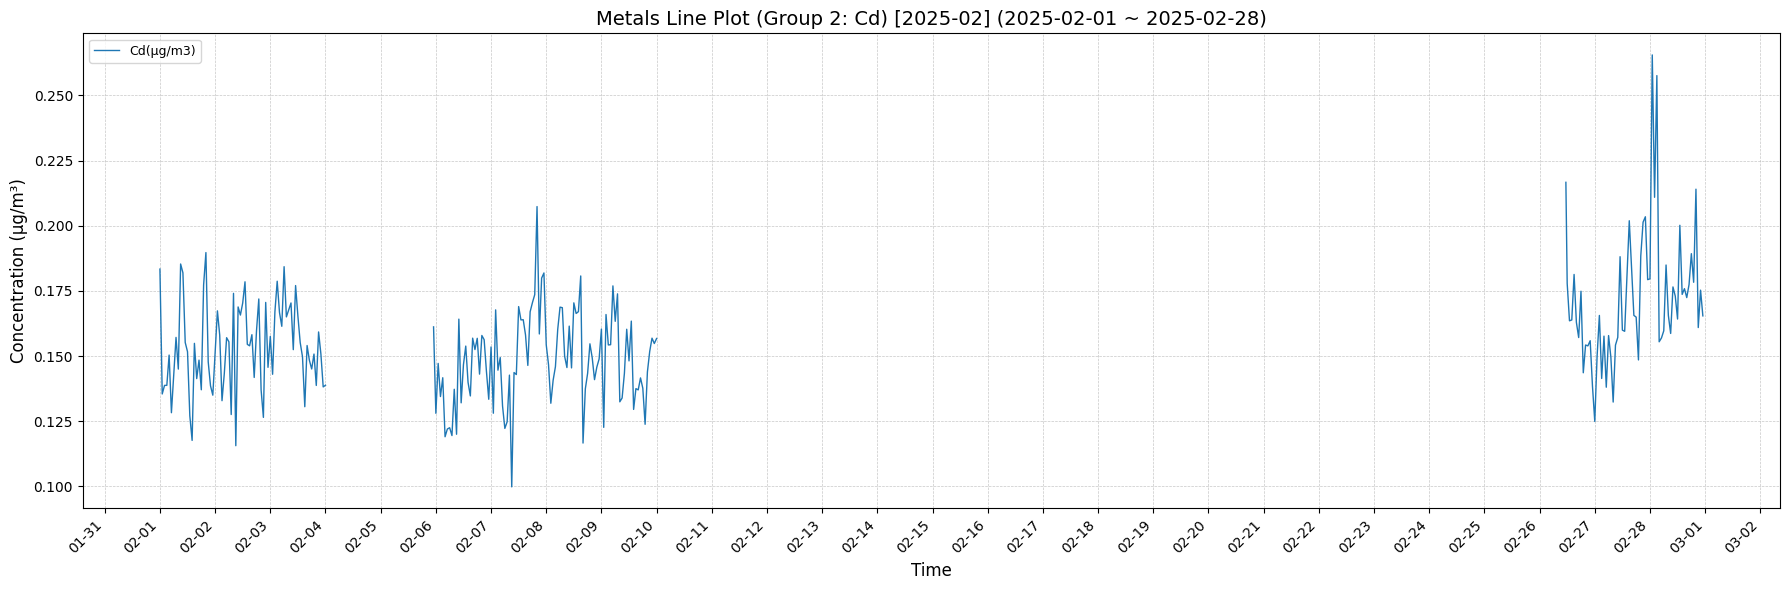

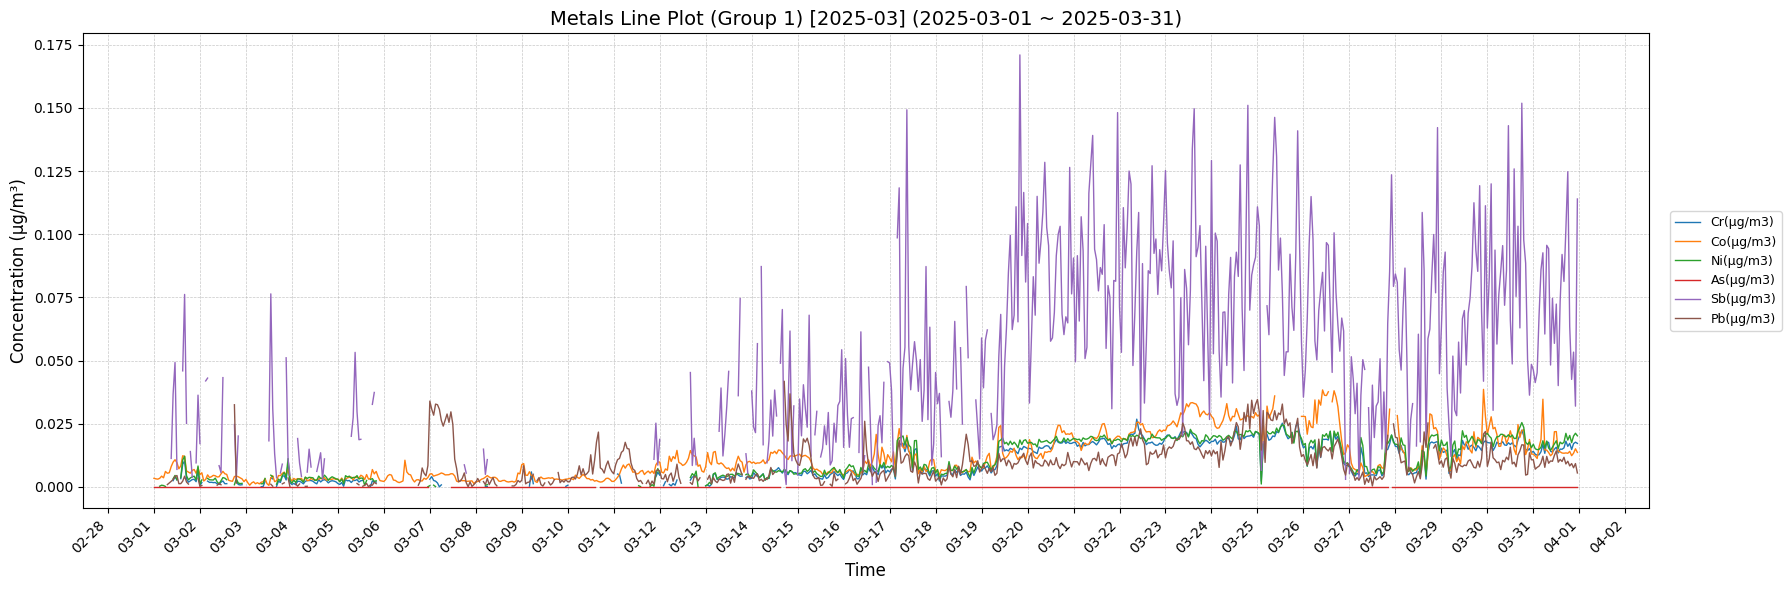

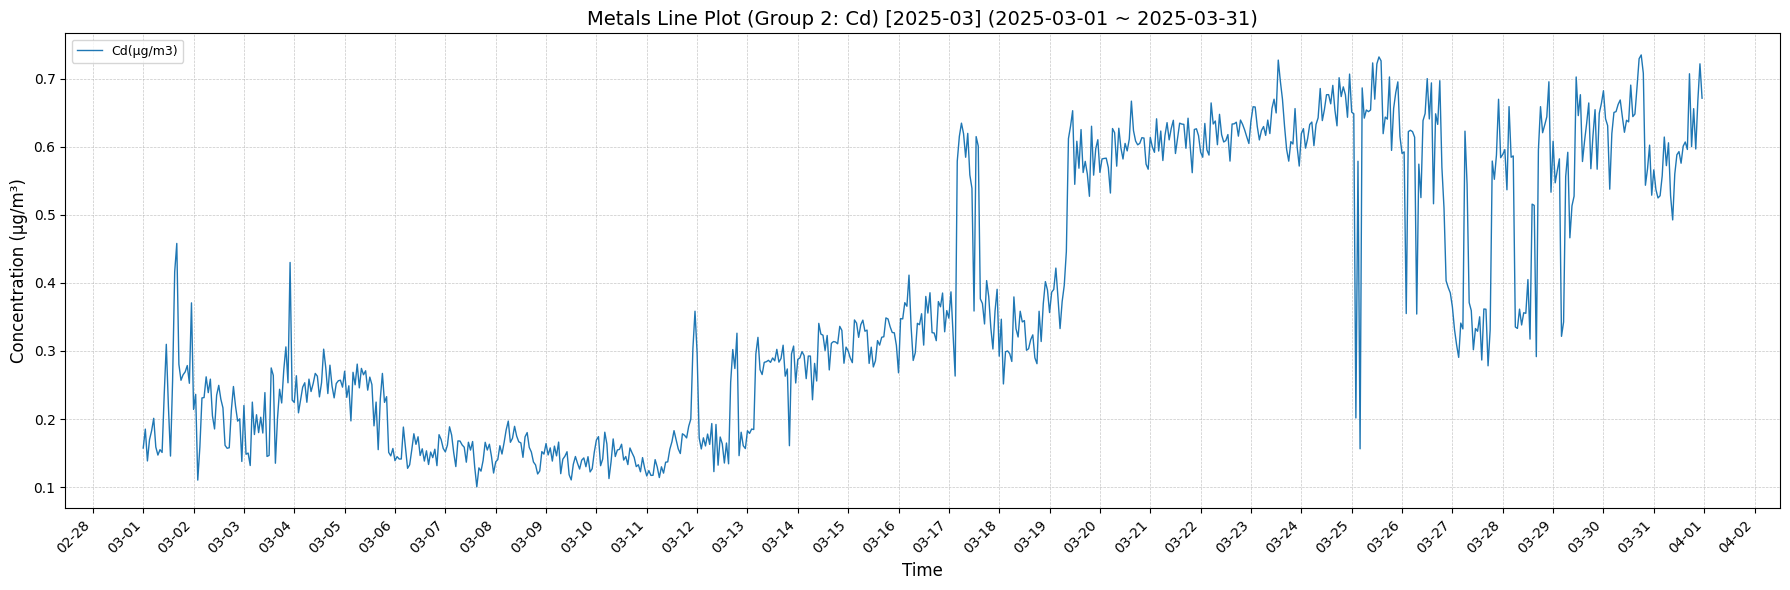

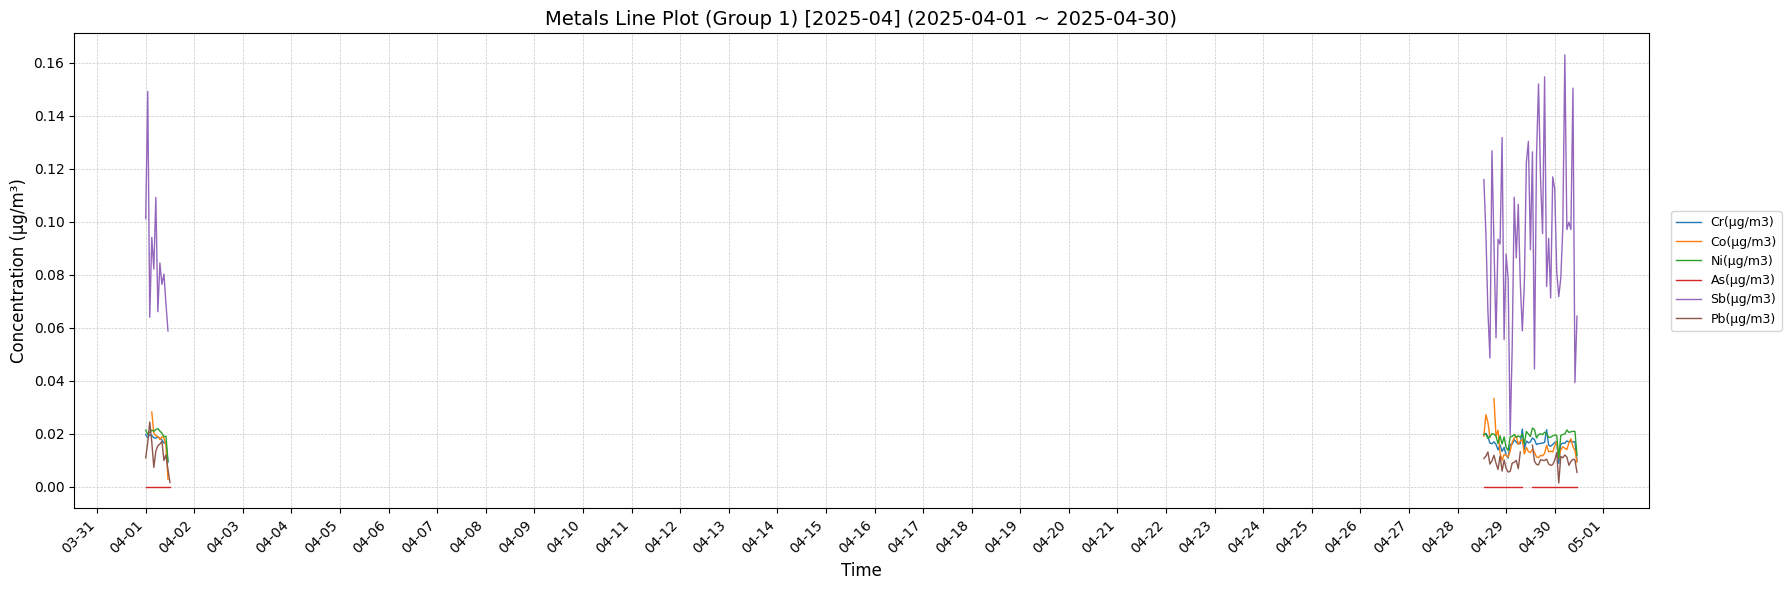

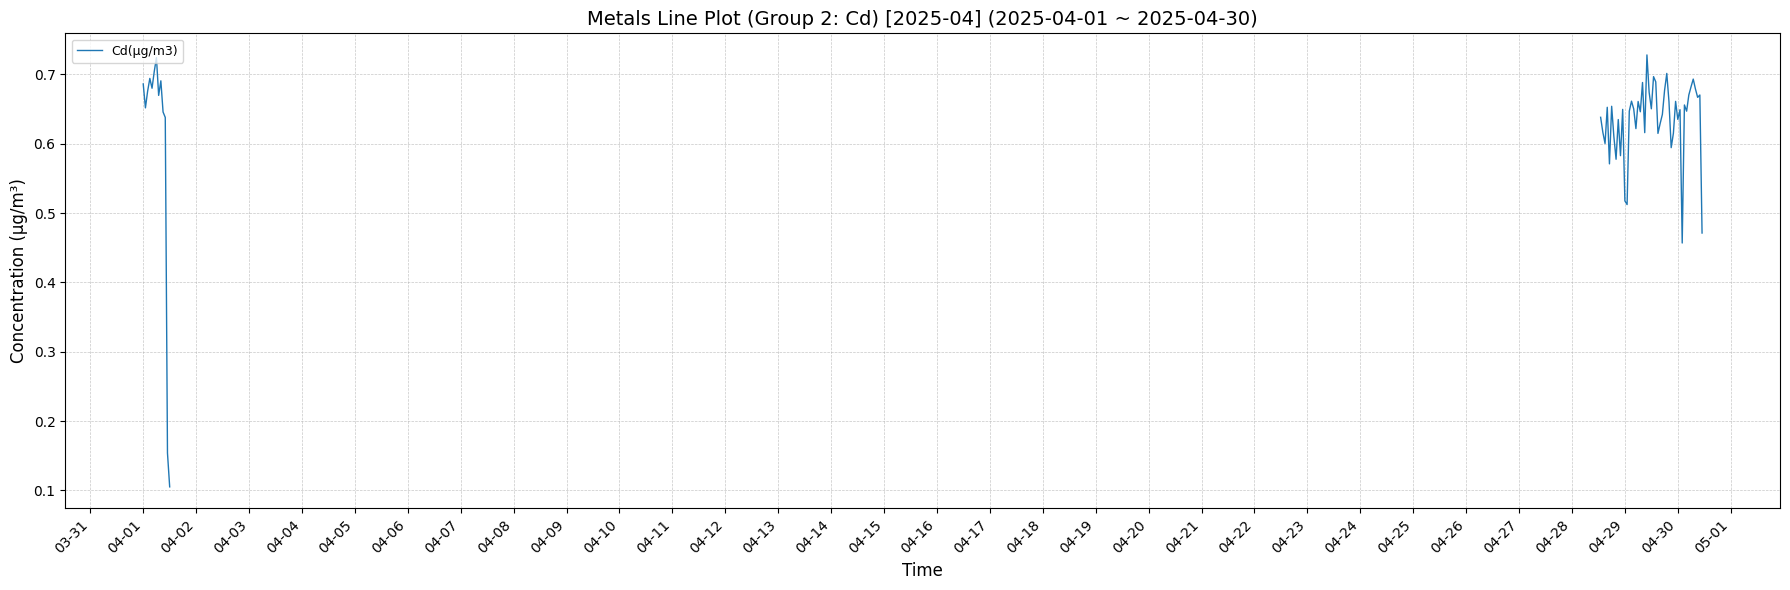

In [5]:
import io, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 1. 파일 업로드
# ============================================================
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Loaded:", filename)

ext = os.path.splitext(filename)[1].lower()
if ext == '.csv':
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
elif ext in ['.xlsx', '.xls']:
    df = pd.read_excel(io.BytesIO(uploaded[filename]))
else:
    raise ValueError("CSV 또는 Excel 파일만 지원합니다.")

# ============================================================
# 2. 시간열 처리 (Pump-Begin / Pump-End)
# ============================================================
if not {"Pump-Begin", "Pump-End"}.issubset(df.columns):
    raise KeyError("파일에 'Pump-Begin', 'Pump-End' 열이 있어야 합니다.")

df["Pump-Begin"] = pd.to_datetime(df["Pump-Begin"])
df["Pump-End"]   = pd.to_datetime(df["Pump-End"])

# 그래프 x축용 시간열 (Pump-Begin 기준)
df["Time"] = df["Pump-Begin"]

# ============================================================
# 3. 금속 컬럼 (ng/m3만) 선택 + 단위 변환
#    - 컬럼 이름에 'ng/m3'가 들어가는 것만 금속으로 간주
# ============================================================
metal_cols_ng = [c for c in df.columns if "ng/m3" in str(c)]

if not metal_cols_ng:
    raise ValueError("'ng/m3'가 포함된 금속 컬럼을 찾지 못했습니다. 컬럼 이름을 한 번 확인해 주세요.")

# 숫자형 변환 후 ng/m3 → µg/m3
for c in metal_cols_ng:
    df[c] = pd.to_numeric(df[c], errors='coerce') / 1000.0  # µg/m3

# 컬럼 이름도 단위 변경
rename_map = {c: str(c).replace("ng/m3", "µg/m3") for c in metal_cols_ng}
df.rename(columns=rename_map, inplace=True)

# 변환된 금속 컬럼 이름들
metal_cols = list(rename_map.values())

# ============================================================
# 4. 날짜 범위 문자열
# ============================================================
t_min = df["Time"].min()
t_max = df["Time"].max()
date_range_str = f"{t_min:%Y-%m-%d} ~ {t_max:%Y-%m-%d}"

title_str = f"All Metals Line Plot ({date_range_str})"

# ============================================================
# 5. 라인 플롯
# ============================================================
import matplotlib.dates as mdates

import matplotlib.dates as mdates

# ------------------------------------------------------------
# 1. 공통: 금속 그룹 설정 (전처리까지 끝났다고 가정)
# ------------------------------------------------------------
group1_names = ["Cr(µg/m3)", "Co(µg/m3)", "Ni(µg/m3)",
                "As(µg/m3)", "Sb(µg/m3)", "Pb(µg/m3)"]
group2_names = ["Cd(µg/m3)"]

group1 = [c for c in group1_names if c in df.columns]
group2 = [c for c in group2_names if c in df.columns]

print("Group1 metals:", group1)
print("Group2 metals:", group2)

# ------------------------------------------------------------
# 2. Time에서 연-월 정보 추출
# ------------------------------------------------------------
df["YearMonth"] = df["Time"].dt.to_period("M")   # 예: 2025-01, 2025-02 ...

unique_months = sorted(df["YearMonth"].unique())
print("월별 구간:", unique_months)

# ------------------------------------------------------------
# 3. 월별로 데이터를 잘라서 그래프 반복 출력
# ------------------------------------------------------------
for ym in unique_months:
    sub = df[df["YearMonth"] == ym].copy()
    if sub.empty:
        continue

    # 이 월의 날짜 범위
    t_min = sub["Time"].min()
    t_max = sub["Time"].max()
    date_range_str = f"{t_min:%Y-%m-%d} ~ {t_max:%Y-%m-%d}"

    # x축: 이 월 안에서는 1일 간격 눈금이 보기 좋음
    locator = mdates.DayLocator(interval=1)
    formatter = mdates.DateFormatter('%m-%d')   # 월-일만 표시 (01-10 등)

    # ------------------ 그래프 1: Group1 ------------------
    if group1:
        fig1, ax1 = plt.subplots(figsize=(18, 6))
        for col in group1:
            ax1.plot(sub["Time"], sub[col], linewidth=1, label=col)

        ax1.set_title(f"Metals Line Plot (Group 1) [{ym}] ({date_range_str})",
                      fontsize=14)
        ax1.set_xlabel("Time", fontsize=12)
        ax1.set_ylabel("Concentration (µg/m³)", fontsize=12)

        ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax1.xaxis.set_major_locator(locator)
        ax1.xaxis.set_major_formatter(formatter)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

        ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=9)
        plt.tight_layout()
        plt.show()

    # ------------------ 그래프 2: Group2(Cd) ------------------
    if group2:
        fig2, ax2 = plt.subplots(figsize=(18, 6))
        for col in group2:
            ax2.plot(sub["Time"], sub[col], linewidth=1, label=col)

        ax2.set_title(f"Metals Line Plot (Group 2: Cd) [{ym}] ({date_range_str})",
                      fontsize=14)
        ax2.set_xlabel("Time", fontsize=12)
        ax2.set_ylabel("Concentration (µg/m³)", fontsize=12)

        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.xaxis.set_major_locator(locator)
        ax2.xaxis.set_major_formatter(formatter)
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

        ax2.legend(loc='upper left', fontsize=9)
        plt.tight_layout()
        plt.show()




Saving 202501_04_clean.xlsx to 202501_04_clean (6).xlsx
Loaded: 202501_04_clean (6).xlsx
금속 컬럼(µg/m3): ['Cr(µg/m3)', 'Co(µg/m3)', 'Ni(µg/m3)', 'As(µg/m3)', 'Cd(µg/m3)', 'Sb(µg/m3)', 'Pb(µg/m3)']
[Cr(µg/m3)] 95th percentile = 0.019688000000000004
[Co(µg/m3)] 95th percentile = 0.026394999999999995
[Ni(µg/m3)] 95th percentile = 0.02084
[As(µg/m3)] 95th percentile = 0.0
[Cd(µg/m3)] 95th percentile = 0.6562169999999999
[Sb(µg/m3)] 95th percentile = 0.114942
[Pb(µg/m3)] 95th percentile = 0.028288000000000004

=== 금속별 고농도 이벤트 요약 ===
         Metal event_id               start                 end  \
70   Cd(µg/m3)        2 2025-03-20 15:00:00 2025-03-20 15:00:00   
71   Cd(µg/m3)        4 2025-03-22 05:00:00 2025-03-22 05:00:00   
72   Cd(µg/m3)        6 2025-03-23 01:00:01 2025-03-23 02:00:01   
73   Cd(µg/m3)        8 2025-03-23 10:00:00 2025-03-23 11:00:01   
74   Cd(µg/m3)       10 2025-03-23 13:00:00 2025-03-23 15:00:00   
..         ...      ...                 ...                 ...   

/tmp/ipython-input-2010230391.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events_all_df = pd.concat(all_events, ignore_index=True)


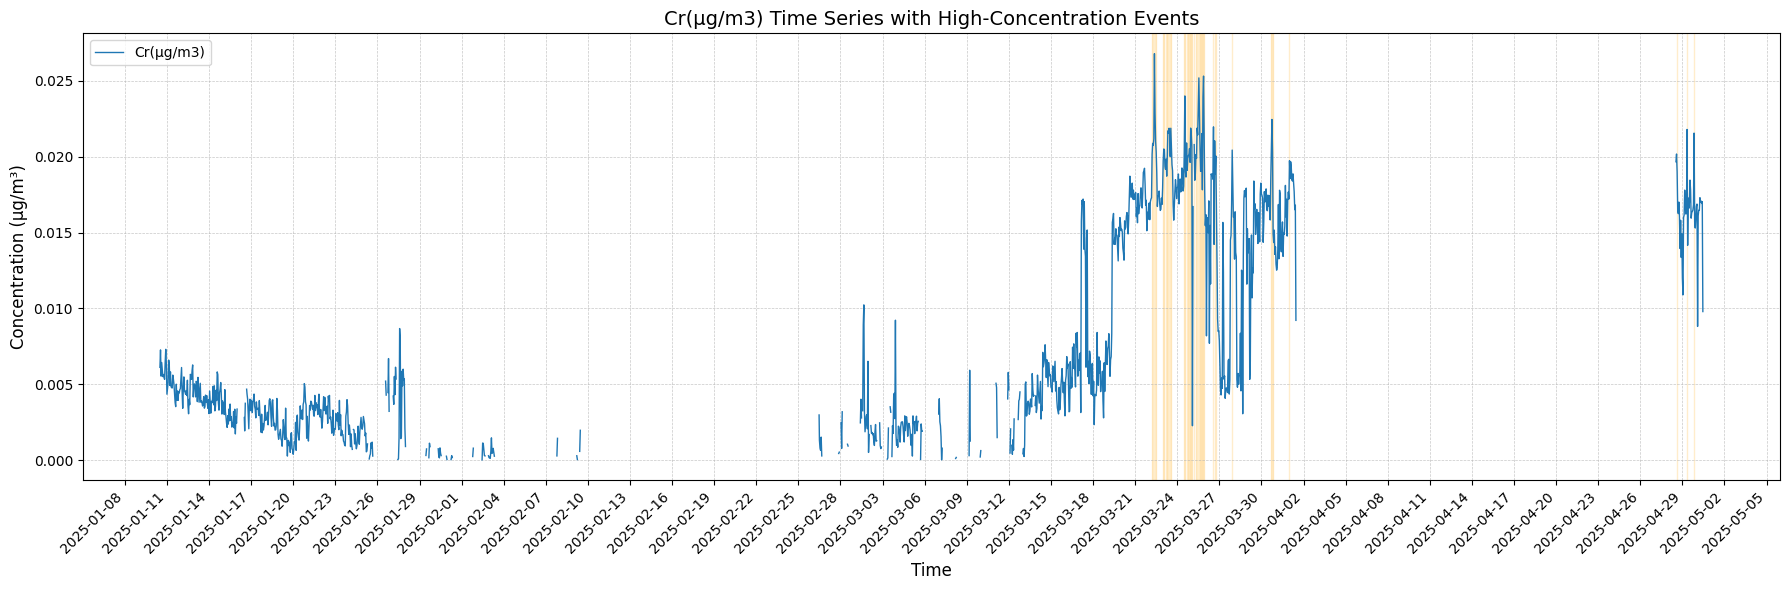

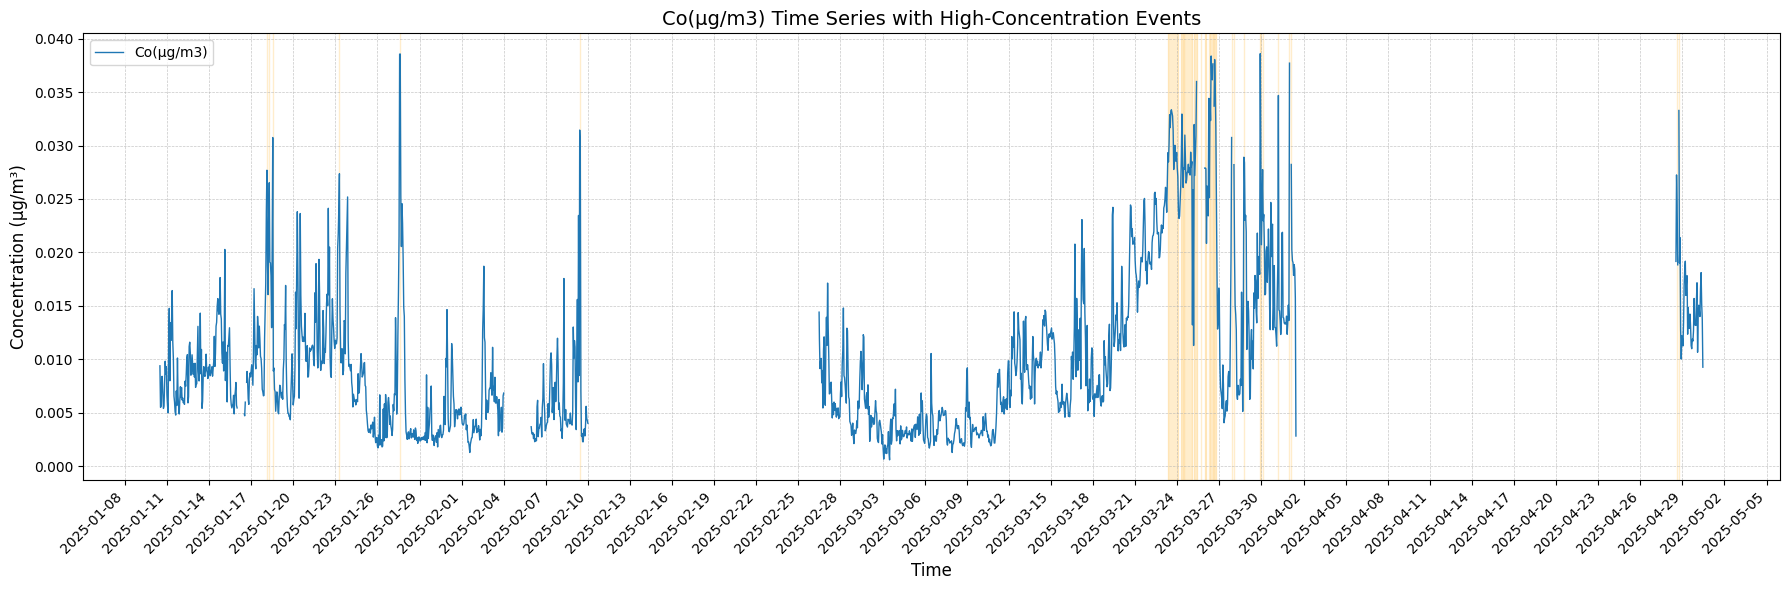

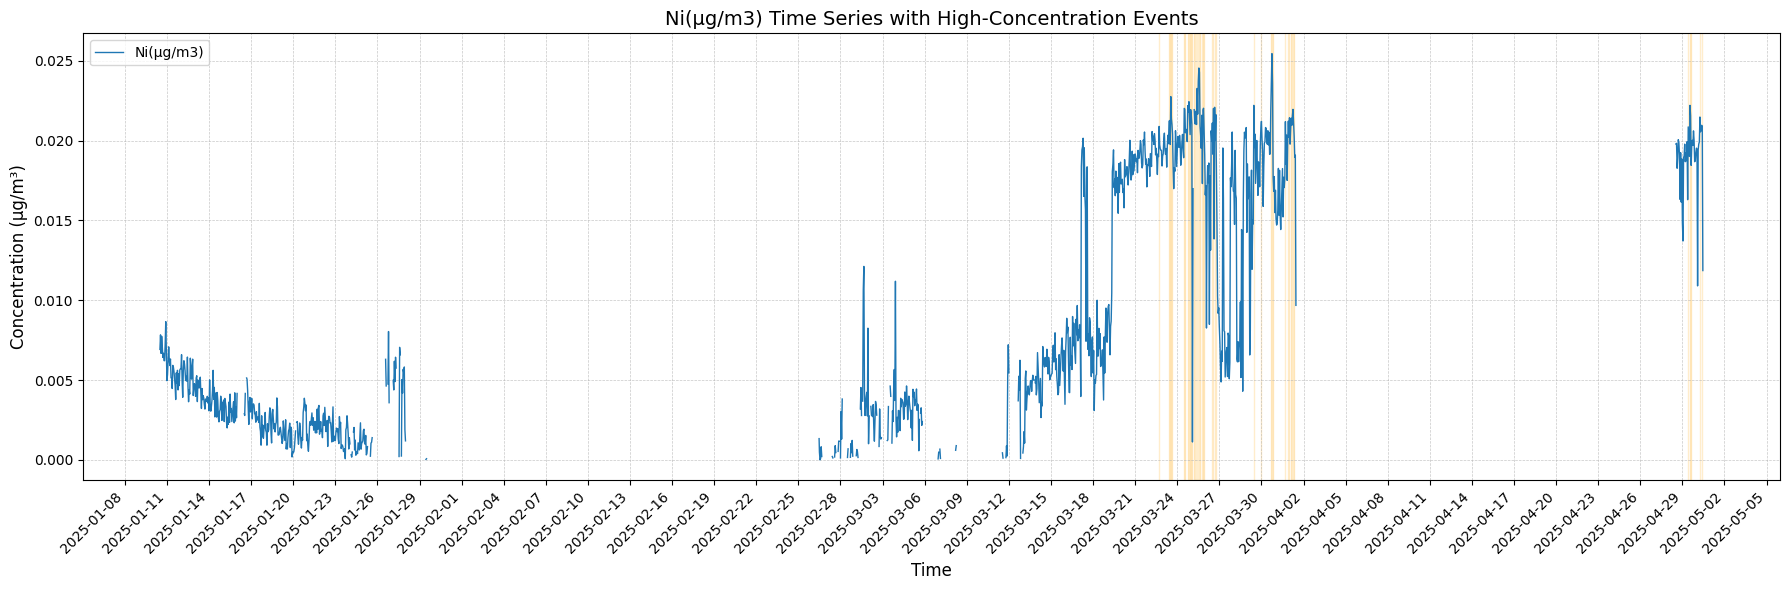

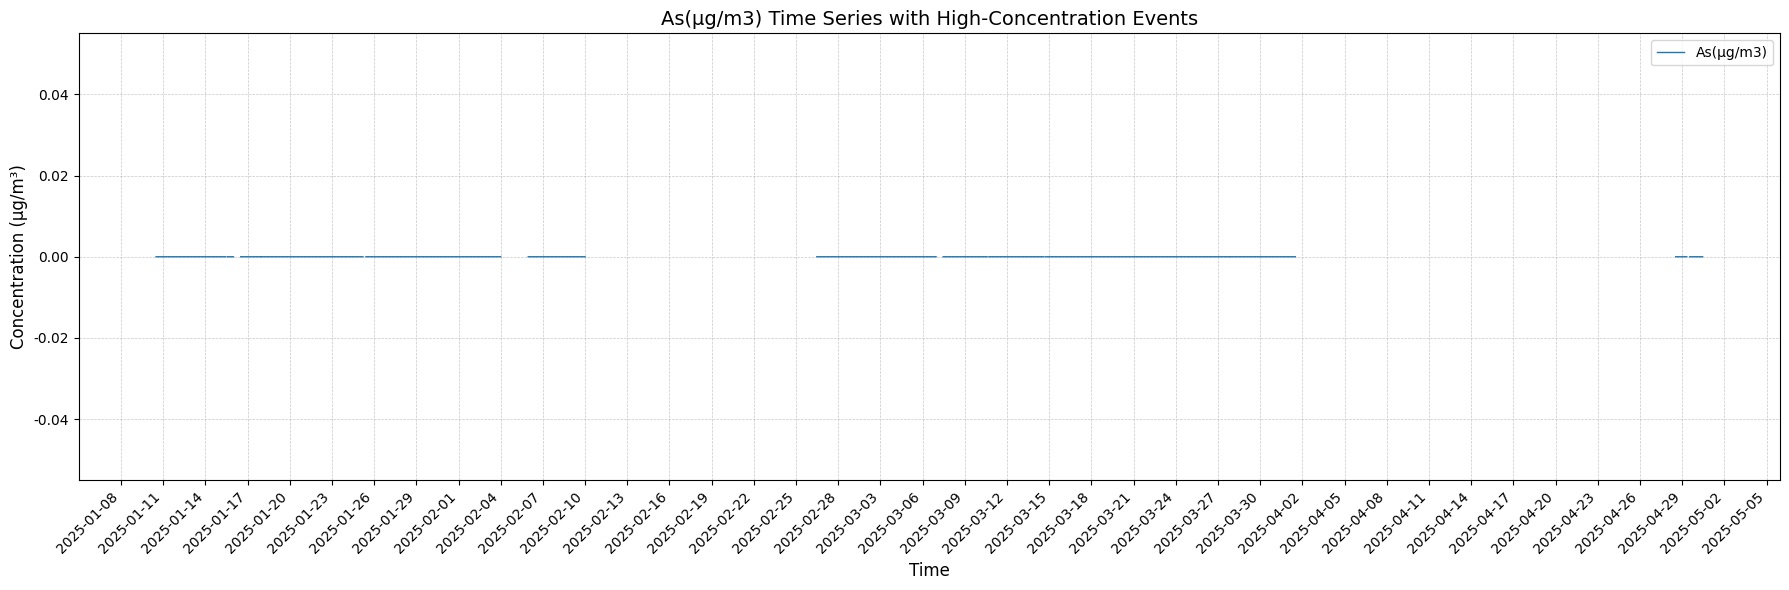

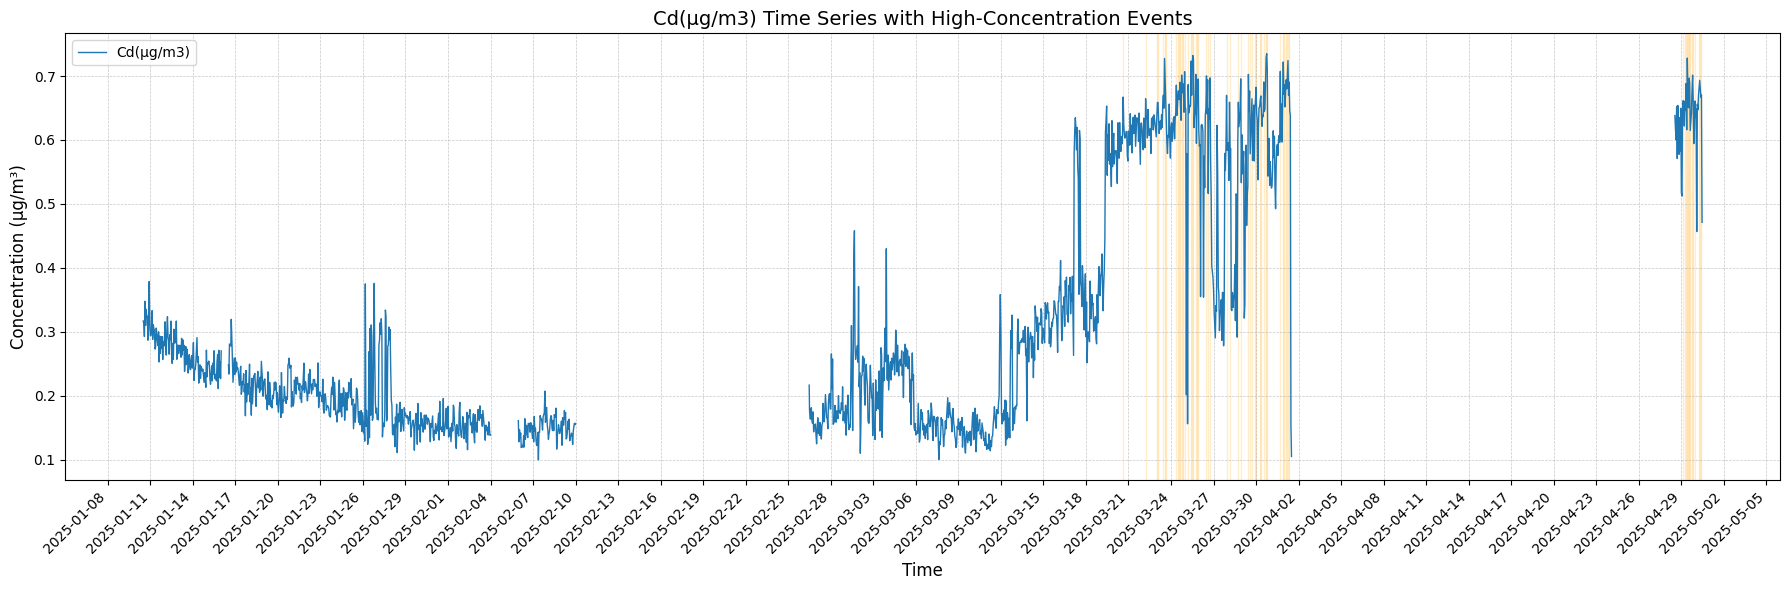

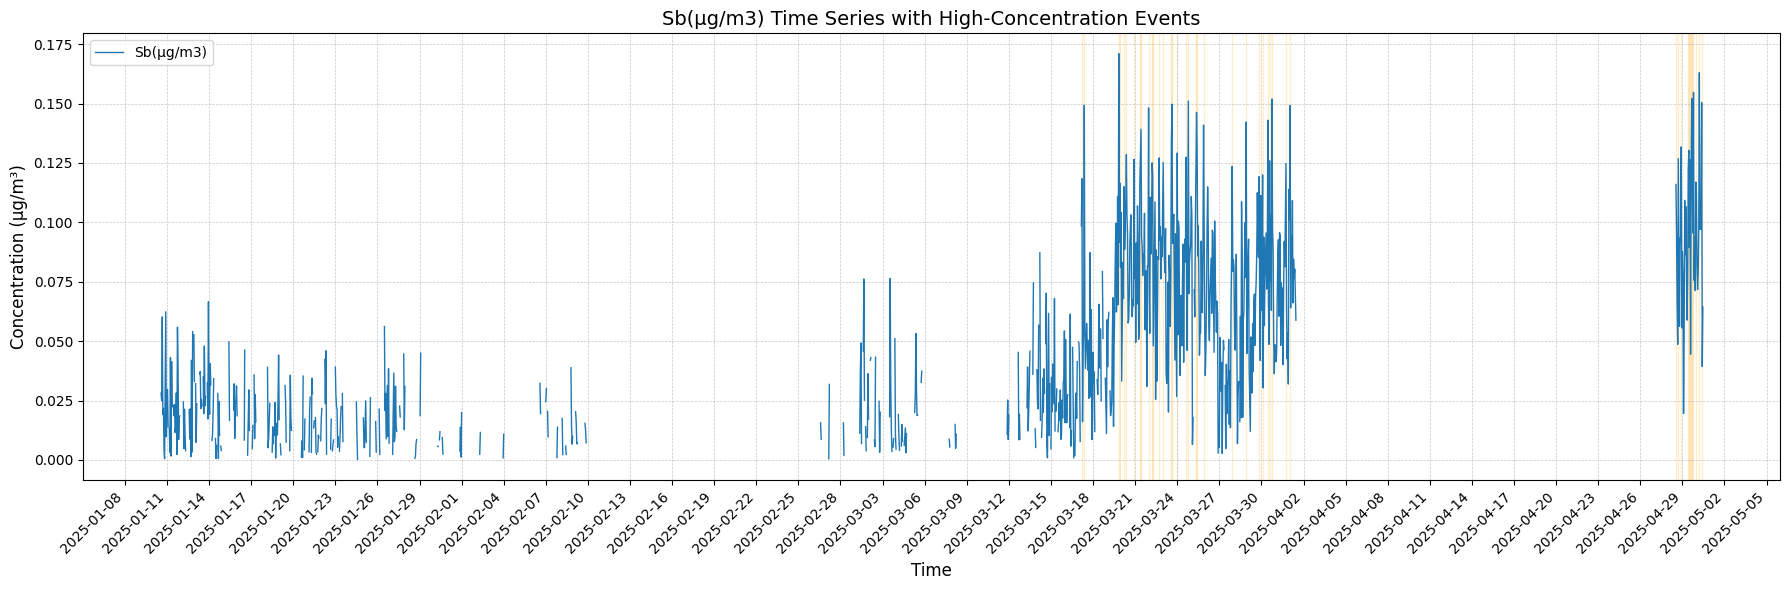

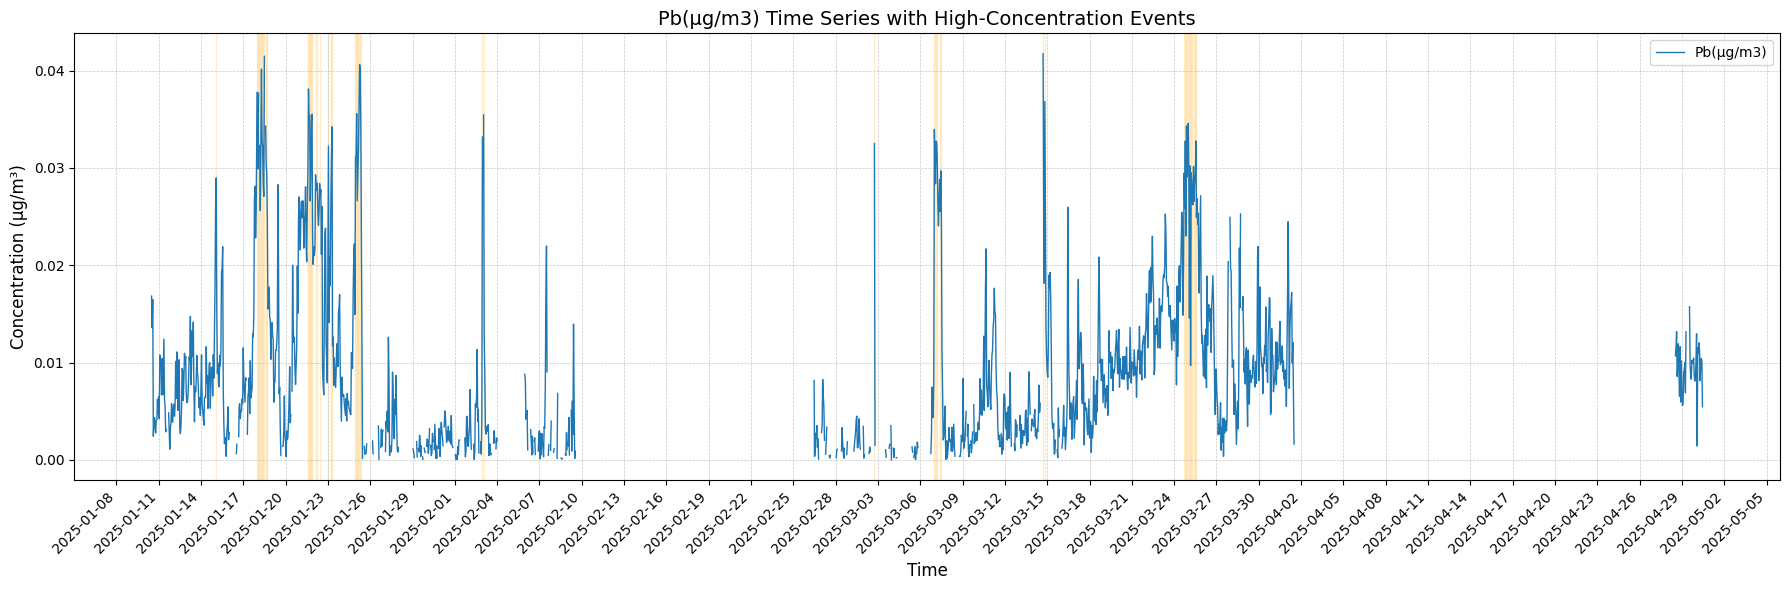

In [8]:
# ============================================================
# 0. 라이브러리
# ============================================================
import io, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.dates as mdates

plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 1. 파일 업로드 (CSV / XLSX 모두 지원)
# ============================================================
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Loaded:", filename)

ext = os.path.splitext(filename)[1].lower()
if ext == '.csv':
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
elif ext in ['.xlsx', '.xls']:
    df = pd.read_excel(io.BytesIO(uploaded[filename]))
else:
    raise ValueError("CSV 또는 Excel 파일만 지원합니다.")

# ============================================================
# 2. 시간열 처리 (Pump-Begin / Pump-End) → Time 생성
# ============================================================
if not {"Pump-Begin", "Pump-End"}.issubset(df.columns):
    raise KeyError("파일에 'Pump-Begin', 'Pump-End' 열이 있어야 합니다.")

df["Pump-Begin"] = pd.to_datetime(df["Pump-Begin"])
df["Pump-End"]   = pd.to_datetime(df["Pump-End"])

# 분석용 기준 시간열 (여기서는 Pump-Begin 사용)
df["Time"] = df["Pump-Begin"]

# ============================================================
# 3. 금속 컬럼 선택 및 단위 변환 (ng/m3 → µg/m3)
#    - 컬럼 이름에 'ng/m3' 포함된 열을 금속 농도로 간주
# ============================================================
metal_cols_ng = [c for c in df.columns if "ng/m3" in str(c)]

if not metal_cols_ng:
    raise ValueError("'ng/m3'가 포함된 금속 컬럼을 찾을 수 없습니다. 헤더명을 확인하세요.")

# 숫자형 변환 + ng/m3 → µg/m3
for c in metal_cols_ng:
    df[c] = pd.to_numeric(df[c], errors='coerce') / 1000.0   # µg/m3

# 컬럼명 단위 표시 바꾸기
rename_map = {c: str(c).replace("ng/m3", "µg/m3") for c in metal_cols_ng}
df.rename(columns=rename_map, inplace=True)

# 최종 금속 컬럼 목록 (µg/m3 단위)
metal_cols = list(rename_map.values())
print("금속 컬럼(µg/m3):", metal_cols)

# ============================================================
# 4. 고농도 이벤트 탐지 함수 정의
# ============================================================
def detect_events_for_metal(df, metal, q=0.95):
    """
    df    : Time 컬럼 포함된 DataFrame
    metal : 분석할 금속 컬럼명 (예: 'Co(µg/m3)')
    q     : 상위 quantile (0.95 = 95백분위수 기준)
    """
    if metal not in df.columns:
        raise KeyError(f"{metal} 컬럼이 없습니다.")

    thr = df[metal].quantile(q)
    print(f"[{metal}] {int(q*100)}th percentile =", thr)

    tmp = df.copy()
    tmp["is_event"] = tmp[metal] > thr
    tmp["event_group"] = (tmp["is_event"] != tmp["is_event"].shift()).cumsum()

    events = []
    for gid, sub in tmp[tmp["is_event"]].groupby("event_group"):
        events.append({
            "Metal": metal,
            "event_id": gid,
            "start": sub["Time"].min(),
            "end":   sub["Time"].max(),
            "duration_hour": (sub["Time"].max() - sub["Time"].min()) / np.timedelta64(1, "h"),
            "max_conc": sub[metal].max(),
            "mean_conc": sub[metal].mean(),
            "n_points": len(sub)
        })

    if not events:
        return pd.DataFrame(columns=[
            "Metal","event_id","start","end",
            "duration_hour","max_conc","mean_conc","n_points"
        ])
    return pd.DataFrame(events)

# ============================================================
# 5. 모든 금속에 대해 고농도 이벤트 탐지
#    - q: 상위 분위수 (필요 시 0.97, 0.99 등으로 조절)
# ============================================================
Q_THRESHOLD = 0.95   # 이 값을 조절하면서 테스트(0.95, 0.97, 0.99 등)

all_events = []
for m in metal_cols:
    ev_df = detect_events_for_metal(df, m, q=Q_THRESHOLD)
    all_events.append(ev_df)

events_all_df = pd.concat(all_events, ignore_index=True)
events_all_df = events_all_df.sort_values(["Metal", "start"])

print("\n=== 금속별 고농도 이벤트 요약 ===")
print(events_all_df)

# 엑셀로 저장
out_name = f"high_conc_events_summary_q{int(Q_THRESHOLD*100)}.xlsx"
events_all_df.to_excel(out_name, index=False)
print("\n저장 완료:", out_name)

# ============================================================
# 6. 모든 금속에 대해 타임시리즈 + 이벤트 하이라이트 시각화
# ============================================================

for metal_to_plot in metal_cols:
    if metal_to_plot not in df.columns:
        print(f"[skip] {metal_to_plot} 컬럼 없음")
        continue

    ev_sel = events_all_df[events_all_df["Metal"] == metal_to_plot]

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(df["Time"], df[metal_to_plot], linewidth=1, label=metal_to_plot)

    # 이벤트 구간 음영 표시 (없으면 그냥 통과)
    for _, row in ev_sel.iterrows():
        ax.axvspan(row["start"], row["end"], color='orange', alpha=0.2)

    ax.set_title(f"{metal_to_plot} Time Series with High-Concentration Events", fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Concentration (µg/m³)", fontsize=12)

    locator = mdates.DayLocator(interval=3)
    formatter = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()